In [1]:
import numpy
import sys
sys.path.append("..")
import physics
from astropy.io import fits
from scipy.interpolate import interp1d
import math
import scipy.constants as p
import pandas as pd
import matplotlib.pyplot as plt
import timeit
%precision %.4g

'%.4g'

<h1>Thermalization</h1>



<p>
This is perhaps the easiest process to model, and is where all electrons eventually end up once beneath the first inductive step corresponding to the lowest excitation energy of hydrogen. 

The preliminary source for cross sections is this paper: [https://arxiv.org/pdf/0910.4410.pdf]
</p>

<p> $ \sigma_{ee}=\frac{40\pi e^2}{E^2}ln(\Lambda)(\frac{0.05}{f})$
As long as $f<0.05$, the results are the same within the error; $ln(\Lambda) \sim 10$. </p>


<p> There is no output spectra; all output is stored as heat.</p>



In [2]:
def thermalize_cs(T, f=0.05, lnV=10):
    '''
    Calculates the heating cross section (xsec) at a particular kinetic energy.
    
    Parameters
    ----------
    T : float, ndarray
        The electron's initial kinetic energy.
    f : float
        The fraction of energy lost in each interaction.
    lnV : float
        The Coulomb logarithm [ln(Lambda)]

    Returns
    ----------
    float, ndarray (same as T)
        The cross section for heating at energy T 
        (given in cm^2). 
    
    See Also
    --------
    heating_dE : Preferred; finds dE/dt
    '''
   
    
    sigma_ee=(7.82*10**(-11))*(0.05/f)*lnV*(T)**(-2)
    return sigma_ee


In [3]:
def heating_dE(T, x_e, rs, nH=physics.nH):
    '''
    Calculates the heating loss rate for electrons at a particular 
    kinetic energy given some ionization fraction and redshift.
    
    Parameters
    ----------
    T : float, ndarray
        The electron's initial kinetic energy
    x_e : float
        The ionization fraction for Hydrogen.
    rs : float
        The redshift (1+z) during heating; used for n_e.
    nH : float
        Hydrogen density from physics.py
        
    Returns
    ----------
    float, ndarray (same as T)
        The energy loss rate from heating (negative).
    
    '''
    
    lnV=10
    n_e = x_e*nH*rs**3  #cm^-3
    # from x_e=n_e/n_h/rs^3 
    
    e_charge=4.80326*10**-10 #esu units
    mv=((T**2+2*T*physics.me)**0.5*physics.me/(T+physics.me)) 
    numfac=(10**-14*physics.ele**-2*physics.c)
    
    dE_dt = numfac*(-4*math.pi*(e_charge)**4*n_e*lnV)/mv
    
    
    return dE_dt

In [4]:
#Examples and testing for heating_dE and thermalize
print('Heating test 1 return:')
heating_dE(100, 0.9, 1000)

Heating test 1 return:


-0.001304

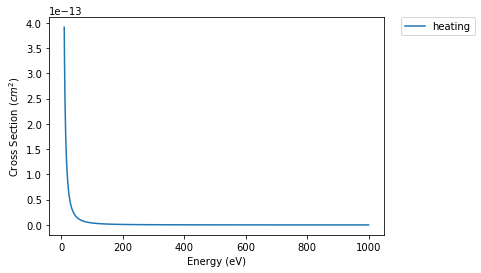

In [5]:
#Log plot of ionization cross section from thermalize_cs
x=numpy.logspace(1,3)
plt.plot(x,thermalize_cs(x,1), label="heating")

plt.xlabel('Energy (eV)')
plt.ylabel('Cross Section ($cm^2$)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

<h1>Ionization</h1>

<p>
Ionization produces an electron spectrum, with one primary losing energy and generating a free secondary. The energy of the primary decreases by the ionization energy and the energy spectra of the secondary. The percent of hydrogen ionized is a stored parameter and main focus of the code. 

The preliminary source for cross sections is this paper: 

[https://journals.aps.org/pra/pdf/10.1103/PhysRevA.50.3954]
</p>

<p>
$ \sigma_i(t)=\frac{S}{t+u+1}[D(t)ln(t)+(2-\frac{N_i}{N})(\frac{t-1}{t}-\frac{ln(t)}{t+1})] $
</p>
<p>
with $D(t)$ given as 
$ D(t)\equiv \int_{0}^{(t-1)/2} \frac{1}{w+1}\frac{df(w)}{dw} dw$

and $t=T/B$, $w=W/B$, $u=U/B$, $Q=\frac{2BM_i^2}{NR}$, and $S=4\pi a_0^2 N(R/B)^2$.

The parameters needed for each ionization are then 
$ f(w), N_i, N, B, S, U,... $ </p>

<p>Secondary Spectra:
These spectra are found from the singly differential cross section as above (see [http://physics.nist.gov/PhysRefData/Ionization/intro.html])
</p>

In [64]:
def ionize_cs(Energy, atoms):
    
    '''
    Calculates the ionization cross section (xsec) for electrons 
    impacting one of (H, He, He+) at a particular kinetic energy.
    
    Parameters
    ----------
    Energy : ndarray
        Each electron's initial kinetic energy.
    atoms : ndarray (same size as Energy)
        Indicates a xsec corresponding to each
        element of Energy (1=H, 2=He, 3=He+)

    Returns
    ----------
    ndarray
        The cross section for ionization for 
        each pair (Energy[n],atoms[n])
        (given in cm^2). 
    
    See Also
    --------
    ionize_s_cs : Often preferred; gives singly differential xsec
    '''
    #initialize return variable
    sigma = numpy.zeros(len(atoms))
    
    for n in range(len(Energy)):
        T=Energy[n]
        atom=atoms[n]
        
        if atom==1: #H
            B=13.6057 #eV: binding energy
            U=13.6057 #eV: 
            t=T/B
            D= (2834163/10+2*(-4536259-10736505*t - 7512905*t**(2) + 112365*t**(3))/(5*(1+t)**(5)))/1000000
            N=1 # number of bound electrons in subshell
            N_i= 0.4343 #integral of df/dw from 0 to infinity
        elif atom==2: #He
            B=24.59 #eV
            U=39.51 #eV
            t=T/B
            D= 1/2*(53047/60-(4*(-58971+227814*t-78435*t**2+121780*t**3))/(15*(1+t)**6))/1000
            N=2
            N_i=1.605
        elif atom==3: #He+
            B=13.6057*4 #eV: scaled by Z^2
            U=13.6057*4 #eV: scaled by Z^2
            t=T/B
            D= (2834163/10+2*(-4536259-10736505*t - 7512905*t**(2) + 112365*t**(3))/(5*(1+t)**(5)))/1000000 #same as H
            N=1
            N_i=0.4343 #seems same as H in approx
        else:
            print('error: some atom incorrectly specified')
            return
        u=U/B 
        S=4*math.pi*p.value('Bohr radius')**2*N*(13.6057/B)**2 #m^2

        sigma_i=S/(t+u+1)*(D*numpy.log(t)+(2-N_i/N)*((t-1)/t-numpy.log(t)/(t+1)))*(10**4) #cm^2
        #replace negatives with zero
        if sigma_i<0:
            sigma_i=0

        sigma[n]=sigma_i

    return sigma

In [84]:
ionize_cs(numpy.array([100, 60, 3]), numpy.array([1,2,3]))

array([  5.77804715e-17,   2.82374489e-17,   0.00000000e+00])

In [85]:
def ionize_s_cs(E_in, E_sec, atoms):
    
    '''
    Calculates the singly-differential ionization cross section (xsec) 
    for electrons impacting one of (H, He, He+) at a particular 
    kinetic energy of the incident and one secondary electron. 
    
    Parameters
    ----------
    E_in : ndarray
        Each electron's initial kinetic energy (eV).
    E_out : ndarray
        The energy of one secondary electron for each initial electron (eV).
    atoms : ndarray
        Atomic xsec relevant to each ionization; (1=H, 2=He, 3=He+)

    Returns
    ----------
    ndarray
        The cross section for ionization at each incident energy (E_in[n]), 
        secondary energy (E_out[n]), and atomic xsec (atoms[n]); (given in cm^2). 
    
    See Also
    --------
    ionize_cs : Gives total ionization xsec
    '''
    
    #initialize return variable
    sigma=numpy.zeros(len(atoms))
    
    for n in range(len(atoms)):
        T=E_in[n]
        W=E_sec[n]
        atom=atoms[n]
        
        if atom==1: #H
            B=13.6057 #eV: binding energy
            U=13.6057 #eV: 
            t=T/B
            w=W/B
            y=1/(w+1)
            df_dw=-0.022473*y**2+1.1775*y**3-0.46264*y**4+0.089064*y**5
            N=1 # number of bound electrons in subshell
            N_i= 0.4343 #integral of df/dw from 0 to infinity
        elif atom==2: #He
            B=24.59 #eV
            U=39.51 #eV
            t=T/B
            w=W/B
            y=1/(w+1)
            df_dw=12.178*y**3-29.585*y**4+31.251*y**5-12.175*y**6
            N=2
            N_i=1.605
        elif atom==3: #He+
            B=13.6057*4 #eV: scaled by Z^2
            U=13.6057*4 #eV: scaled by Z^2
            t=T/B
            w=W/B
            y=1/(w+1)
            df_dw=-0.022473*y**2+1.1775*y**3-0.46264*y**4+0.089064*y**5
            N=1
            N_i=0.4343 #seems same as H in approx
        else:
            print('error: atom incorrectly specified')
            return

        u=U/B 
        S=4*math.pi*p.value('Bohr radius')**2*N*(13.6057/B)**2 #m^2

        sigma_i=S/(B*t+(u+1))*((N_i/N-2)/(t+2)*(1/(w+1)+1/(t-w))+(2-N_i/N)*(1/(W+1)**2+1/(t-w)**2)+ numpy.log(t)/(N*(w+1))*df_dw) #cm^2
        #replace negatives with zero
        if sigma_i < 0:
            sigma_i=0
            
        sigma[n]=sigma_i

    return sigma

In [92]:
ionize_s_cs(numpy.array([102,102,102]), numpy.array([20,20,20]), numpy.array([1,2,3]))

array([  1.33042044e-24,   3.36387592e-23,   5.99013818e-24])

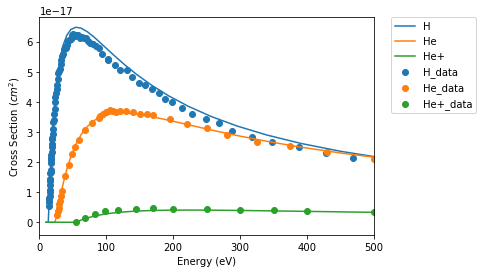

In [98]:
#Log plot of ionization cross sections
x=numpy.logspace(1,4)
y=numpy.ones(len(x))
#x=numpy.linspace(1,300)
plt.plot(x,ionize_cs(x,y), label="H")
plt.plot(x,ionize_cs(x,2*y), label="He")
plt.plot(x,ionize_cs(x,3*y), label="He+")
#Data points

#H
H_i=pd.read_csv('Shah_H_ionization.csv', sep=',',header=None)
a=H_i.values[:,0]
b=H_i.values[:,1]*10**(-17) #cm^2
plt.scatter(a,b, label="H_data")
#He
Hep_i=pd.read_csv('Shah_He_ionization.csv', sep=',',header=None)
e=Hep_i.values[:,0]
f=Hep_i.values[:,1]*10**(-17) #cm^2
plt.scatter(e,f, label="He_data")
#He+
Hep_i=pd.read_csv('Peart_Hep_ionization.csv', sep=',',header=None)
c=Hep_i.values[:,0]
d=Hep_i.values[:,1]*10**(-18) #cm^2
plt.scatter(c,d, label="He+_data")





###############
plt.xlabel('Energy (eV)')
axes = plt.gca()
axes.set_xlim([0,500])
plt.ylabel('Cross Section ($cm^2$)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
#def ionize_sec(T, atom):
    #Returns the seconday spectra following ionization
    #atom: 1=H, 2=He, 3=He+
    
    
    
    

<h1>Excitation</h1>
<p>
Keep in mind that this will produce a singe output electron (use conservation of energy, perhaps looking at probability based on the transition distribution) and a output photon which is given by some transition distribution. We will need this distribution for $2s \rightarrow 1s$ and $2p \rightarrow 1s$ in H, He, and He+. The percent excited is also stored between steps, questionably; the time scale of going back to the ground state confuses this effect for me. 
The preliminary source for cross sections: 

[https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4859265/pdf/j74sto.pdf]
</p>

<h2>H, He</h2>
<p>The total excitation cross section for H and He is of the form:
$\sigma_{BEf}=(f_{accu}/f_{sc})*[T/(T+B+E)]*\sigma_{PWB}$
where $\sigma_{PWB}$ is given as 
$\sigma_{PWB}=\frac{4\pi a_0^2R}{T}*F_{PWB}(T)$
This is the valid form for sub 3keV.

The values for f, B, and E are in the linked paper. 
</p>
<h2>He+</h2>
<p>The best total excitation cross section seems to be from:

[http://iopscience.iop.org/article/10.1088/0022-3700/9/9/016/pdf]

However, He+ presents unique challenges at low energies for ionization given its small Z. 
</p>
<h2>Secondary Spectra</h2>
<p>Good source for $2s\rightarrow 1s$ seems to be:

[https://arxiv.org/pdf/0803.0808.pdf]

For other transitions, Voigt profiles can be placed around the central spectral line with parameters as in:

[http://www.sciencedirect.com/science/article/pii/S0022407304004030]
</p>

In [95]:
def excite_cs(T, atom, transition=2):
    #Calculates cross section for excitation in (cm^2) for a given electron energy T (eV) and parameters of the atom
    #atom: 1=H, 2=He, 3=He+
    #transition 1=1s->2s, 2=1s->2p   // assumes transition=2
    E=T
    sigma=numpy.zeros(len(E))
    for n in range(0,len(E)):
        T=E[n]
        if atom==1: #H
            if T<10.2: #eV
                sigma_e=0

            elif transition==1: #2s
                if T<=11.56: #eV
                    sigma_e=10**(-16)*(0.114+0.0575*(T-10.2)) #cm^2
                elif T<=12.23: #eV
                    sigma_e=1.795*10**(-17) #cm^2
                else:
                    X=T/10.2
                    sigma_e=5.984*10**(-16)/(T)*(0.88606-2.7990/X+5.9451/X**(2)-7.6948/X**(3)+4.4152/X**(4)) #cm^2
            else: #2p
                H2p=pd.read_csv('H_1s-2p_excite_table.csv', sep=',',header=None)
                x=H2p.values[:,0]
                y=H2p.values[:,1]
                f = interp1d(x, y)
                sigma_e=f(T)*10**(-16) #cm^2

        elif atom==2: #He
            if T<21.2:#eV
                sigma_e=0
            elif transition==1: #2s
                sigma_e=0 #Need to find cross section
            else: #2p
                He2p=pd.read_csv('He_1s-2p_excite_table.csv', sep=',',header=None)
                x=He2p.values[:,0]
                y=He2p.values[:,1]
                f = interp1d(x, y)
                sigma_e=f(T)*10**(-16) #cm^2

        else: #He+
            pia2=math.pi*p.value('Bohr radius')**2
            if T<40.8: #eV
                sigma_e=0

            elif transition==1: #2s
                #extra interpolation values of 0 added at 40.8 and max(3keV)
                HeP2s=pd.DataFrame({'CS' : [0, pia2*0.0065, pia2*0.0049, pia2*0.0031, pia2*0.0019, pia2*0.0013, 0], 'Energy' : [40.8, 100., 200., 400., 700., 1000., 3000.]})
                x=HeP2s.values[:,1]
                y=HeP2s.values[:,0]
                f = interp1d(x, y)
                sigma_e=f(T)*10**(4) #cm^2
            else: #2p 
                #extra interpolation values of 0 added at 40.8 and max(3keV)
                HeP2p=pd.DataFrame({'CS' : [0, pia2*0.082, pia2*0.067, pia2*0.048, pia2*0.033, pia2*0.026, 0], 'Energy' : [40.8, 100., 200., 400., 700., 1000., 3000.]})
                x=HeP2p.values[:,1]
                y=HeP2p.values[:,0]
                f = interp1d(x, y)
                sigma_e=f(T)*10**(4) #cm^2

        if sigma_e < 0:
            sigma_e=0
        sigma[n]=sigma_e
        
    
    return sigma

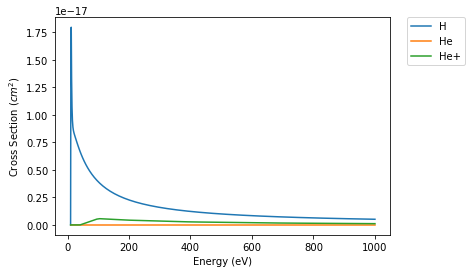

In [96]:
#log plot showing 1s-2s excitation cross sections
x=numpy.logspace(1,3)
#x=numpy.linspace(10,20)
plt.plot(x,excite_cs(x,1,1), label="H")
plt.plot(x,excite_cs(x,2,1), label="He") 
plt.plot(x,excite_cs(x,3,1), label="He+") 


plt.xlabel('Energy (eV)')
plt.ylabel('Cross Section ($cm^2$)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
#log plot showing 1s-2p excitation cross sections
x=numpy.logspace(1,3)
plt.plot(x,excite_cs(x,1,2), label="H")
plt.plot(x,excite_cs(x,2,2), label="He") 
plt.plot(x,excite_cs(x,3,2), label="He+") 


plt.xlabel('Energy (eV)')
plt.ylabel('Cross Section ($cm^2$)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
def excite_sec(T, atom, transition=2):
    #Returns the seconday spectra following ionization
    #atom: 1=H, 2=He, 3=He+
    #transition 1=1s->2s, 2=1s->2p
    #transitions seem unnecessary given similarities in energy
    #output contains electron energy, photon energy
    output=numpy.zeros(2)
    if transition==2:
    
        if atom==1:
            Ep=10.2 #eV
            output[0]=T-Ep
            output[1]=Ep
        elif atom==2:
            Ep=21.2 #eV
            output[0]=T-Ep
            output[1]=Ep
        else:
            Ep=40.8 #eV
            output[0]=T-Ep
            output[1]=Ep
    return output
        

In [ ]:
#Plot all cross sections
#Log plot of ionization cross sections
x=numpy.logspace(0,3)
#x=numpy.linspace(200,1000)
#plt.plot(x,thermalize_cs(x,1), label="heating")
plt.plot(x,ionize_cs(x,1), label="H_i")
plt.plot(x,ionize_cs(x,2), label="He_i") 
plt.plot(x,ionize_cs(x,3), label="He+_i") 
plt.plot(x,excite_cs(x,1,1), label="H_es")
plt.plot(x,excite_cs(x,2,1), label="He_es") 
plt.plot(x,excite_cs(x,3,1), label="He+_es")
plt.plot(x,excite_cs(x,1,2), label="H_ep")
plt.plot(x,excite_cs(x,2,2), label="He_ep") 
plt.plot(x,excite_cs(x,3,2), label="He+_ep")




plt.xlabel('Energy (eV)')
plt.ylabel('Cross Section ($cm^2$)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

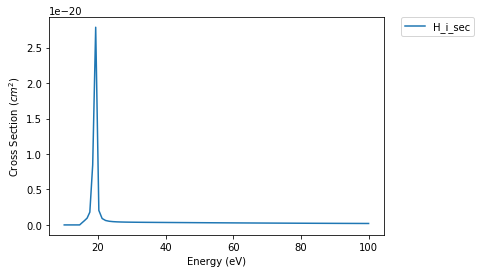

In [99]:
x=numpy.logspace(1,2)
y=x-numpy.array([20])
z=numpy.ones(len(x))
plt.plot(x,ionize_s_cs(x, y, z), label="H_i_sec")

plt.xlabel('Energy (eV)')
plt.ylabel('Cross Section ($cm^2$)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()